# Developing PDC ROP model using symbolic regression and pysr library

### Import neccassary libraries

In [1]:
# !/Users/amin/anaconda3/bin/python -m pip install pysr

In [2]:
import pandas as pd
import numpy as np
from pysr import pysr, best
from sklearn import preprocessing

import matplotlib.pylab as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sys
import math

from tabulate import tabulate
%config InlineBackend.figure_format = 'retina'

* In this study, we use the Sandia National Lab and National Oil Varco full PDC bit data.
* The data was published in ARMA conference 55TH US ROCK MECHANICS / GEOMECHANICS SYMPOSIUM 18-25 June 2021 Online.
* Paper titel is "ROP Model for PDC Bits in Geothermal Drilling".

### Read the PDC ROP data

In [3]:
# inserting the parent directory into current path
sys.path.insert(1, '../OpenSource_ROP_Models/ROP models/A PDC ROP model developed by AI/')
data = pd.read_csv("../A PDC ROP model developed by AI/Data/ROP data.csv")
data.head()
data.head()

,year,name,WOB,ROP data,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2019,SWG,2543.8,6.2,3.75,80,28000,11,25,1,0.51,4
1,2019,SWG,3048.9,11.9,3.75,80,28000,11,25,1,0.51,4
2,2019,SWG,3538.7,19.5,3.75,80,28000,11,25,1,0.51,4
3,2019,SWG,4066.2,28.6,3.75,80,28000,11,25,1,0.51,4
4,2019,SWG,4574.9,36.6,3.75,80,28000,11,25,1,0.51,4


Print data tabulated.

In [33]:
# print(tabulate(data, headers = 'keys', tablefmt = 'github'))
print(tabulate(data,
                headers='keys',
                tablefmt='github',
                floatfmt='g',
                numalign='decimal',
                stralign='left',
                missingval='',
                showindex='None',
                disable_numparse=False,
                colalign=None),
     )

|   year | name       |     WOB |   ROP data |   Db |   RPM |   UCS |   NOC |   BR |   SR |   Dc |   NOB |
|--------|------------|---------|------------|------|-------|-------|-------|------|------|------|-------|
|   2019 | SWG        | 2543.8  |    6.2     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3048.9  |   11.9     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3538.7  |   19.5     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 4066.2  |   28.6     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 4574.9  |   36.6     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 2579.8  |    8.5     | 3.75 |   120 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3051.5  |   14.8     | 3.75 |   120 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3471.8  |   2

Check out the data frame column names.

In [5]:
data.columns

Index(['year', 'name ', 'WOB', 'ROP data', 'Db', 'RPM', 'UCS', 'NOC', 'BR',
       'SR', 'Dc', 'NOB'],
      dtype='object')

Separate the independent (X) and dependant (Y) parameters

In [6]:
keep_clmns = ['WOB', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'SR', 'Dc', 'NOB']
X = data[keep_clmns]

keep_clmns = ['ROP data',]
Y = data[keep_clmns]

Check out the X and Y top 5 values

In [7]:
X.head()

,WOB,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2543.8,3.75,80,28000,11,25,1,0.51,4
1,3048.9,3.75,80,28000,11,25,1,0.51,4
2,3538.7,3.75,80,28000,11,25,1,0.51,4
3,4066.2,3.75,80,28000,11,25,1,0.51,4
4,4574.9,3.75,80,28000,11,25,1,0.51,4


In [8]:
Y.head()

,ROP data
0,6.2
1,11.9
2,19.5
3,28.6
4,36.6


Check out the mean, std, min and max values.

In [9]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
WOB,88.0,2967.525501,986.156551,1090.00,2287.50,3033.55165,3692.50,5088.248694
Db,88.0,3.750000,0.000000,3.75,3.75,3.75000,3.75,3.750000
RPM,88.0,123.636364,28.169512,80.00,100.00,120.00000,150.00,160.000000
UCS,88.0,24437.500000,7904.099220,7100.00,28000.00,28000.00000,28000.00,28000.000000
NOC,88.0,12.454545,2.094926,11.00,11.00,11.00000,13.00,16.000000
BR,88.0,19.204545,4.964608,15.00,15.00,15.00000,25.00,25.000000
SR,88.0,1.000000,0.000000,1.00,1.00,1.00000,1.00,1.000000
Dc,88.0,0.463636,0.039717,0.43,0.43,0.43000,0.51,0.510000
NOB,88.0,4.454545,0.500783,4.00,4.00,4.00000,5.00,5.000000


In [10]:
Y.describe().T

,count,mean,std,min,25%,50%,75%,max
ROP data,88.0,33.051984,27.326698,1.646927,12.2,26.125011,44.375,127.7


Turn pandas data frame into the numpy array. Numpy arrays then will be fed into the pysr algorithm.

In [11]:
X_np = np.array(X)
Y_np = np.array(Y)

In [12]:
print("The X_np shape is ", X_np.shape)
print("The Y_np shape is ", Y_np.shape)

The X_np shape is  (88, 9)
The Y_np shape is  (88, 1)


Flatten the Y numpy.

In [13]:
Y_np_flat = Y_np.flatten()
print("The Y_np_flat shape is ", Y_np_flat.shape)

The Y_np_flat shape is  (88,)


### Run the pysr library

In [14]:
%%time
# learn equation
equations = pysr(X_np,
                Y_np_flat,
                loss="LPDistLoss{2}()",
                procs=10,
                populations=5,
                niterations=5,
                binary_operators=["plus", "sub", "mult", "pow", "div"],
                unary_operators=[],
                verbosity=0, 
                variable_names=['WOB', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'SR', 'Dc', 'NOB'])

I will install Julia packages using PySR's Project.toml file. OK? (y/n): y
OK. I will install at launch.
CPU times: user 67.8 ms, sys: 131 ms, total: 199 ms
Wall time: 3min 31s


Here is the Hall of fame found hall_of_fame_2021-07-13_152922.804.csv.
```
Complexity|MSE|Equation
1|738.2626|33.05189
3|612.86194|pow(Dc, -4.44472)
9|434.80283|(((WOB / 0.007634368) / UCS) - (RPM * -0.14428118))
15|104.25465|((((((RPM - -51.921158) / Dc) * WOB) / 0.7383088) / UCS) - (RPM * 0.22271504))
17|61.724953|(((((((RPM - -49.154247) / Dc) - NOC) * WOB) / 0.7277487) / UCS) - (RPM * 0.2236275))
19|12.594536|(((((((RPM - -51.923843) / Dc) - pow(NOC, 1.5514544)) * WOB) * 1.3547826) / UCS) - (RPM * 0.22286956))
```

Check out the hall of fame equations

In [19]:
equations

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,1,738.262600,0.000000,33.05189,33.0518900000000,PySRFunction(X=>33.0518900000000)
1,3,612.861940,0.093080,"pow(Dc, -4.44472)",Abs(Dc)**(-4.44472),PySRFunction(X=>Abs(Dc)**(-4.44472))
2,9,434.802830,0.057208,(((WOB / 0.007634368) / UCS) - (RPM * -0.14428...,0.14428118*RPM + 130.986612120348*WOB/UCS,PySRFunction(X=>0.14428118*RPM + 130.986612120...
3,15,104.254650,0.238009,((((((RPM - -51.921158) / Dc) * WOB) / 0.73830...,-0.22271504*RPM + 1.35444681141549*WOB*(RPM + ...,PySRFunction(X=>-0.22271504*RPM + 1.3544468114...
4,17,61.724953,0.262074,(((((((RPM - -49.154247) / Dc) - NOC) * WOB) /...,-0.2236275*RPM + 1.37410070261891*WOB*(-NOC + ...,PySRFunction(X=>-0.2236275*RPM + 1.37410070261...
5,19,12.594536,0.794713,"(((((((RPM - -51.923843) / Dc) - pow(NOC, 1.55...",-0.22286956*RPM + 1.3547826*WOB*(-Abs(NOC)**1....,PySRFunction(X=>-0.22286956*RPM + 1.3547826*WO...


Define a function and edit it with the best function found by pysr library.

In [25]:
def best_equation(row):
    WOB, Db, RPM, UCS, NOC, BR, SR, Dc, NOB = row
#     Y= (pow((((((RPM + 98.457596) / Dc) * WOB) / (UCS - WOB)) - NOB) - NOC, 1.1348255) * 0.31298584)
    Y= (((((((RPM - -51.923843) / Dc) - pow(NOC, 1.5514544)) * WOB) * 1.3547826) / UCS) - (RPM * 0.22286956))
    return Y

Compare the results of PDC ROP model found by pysr with the data.

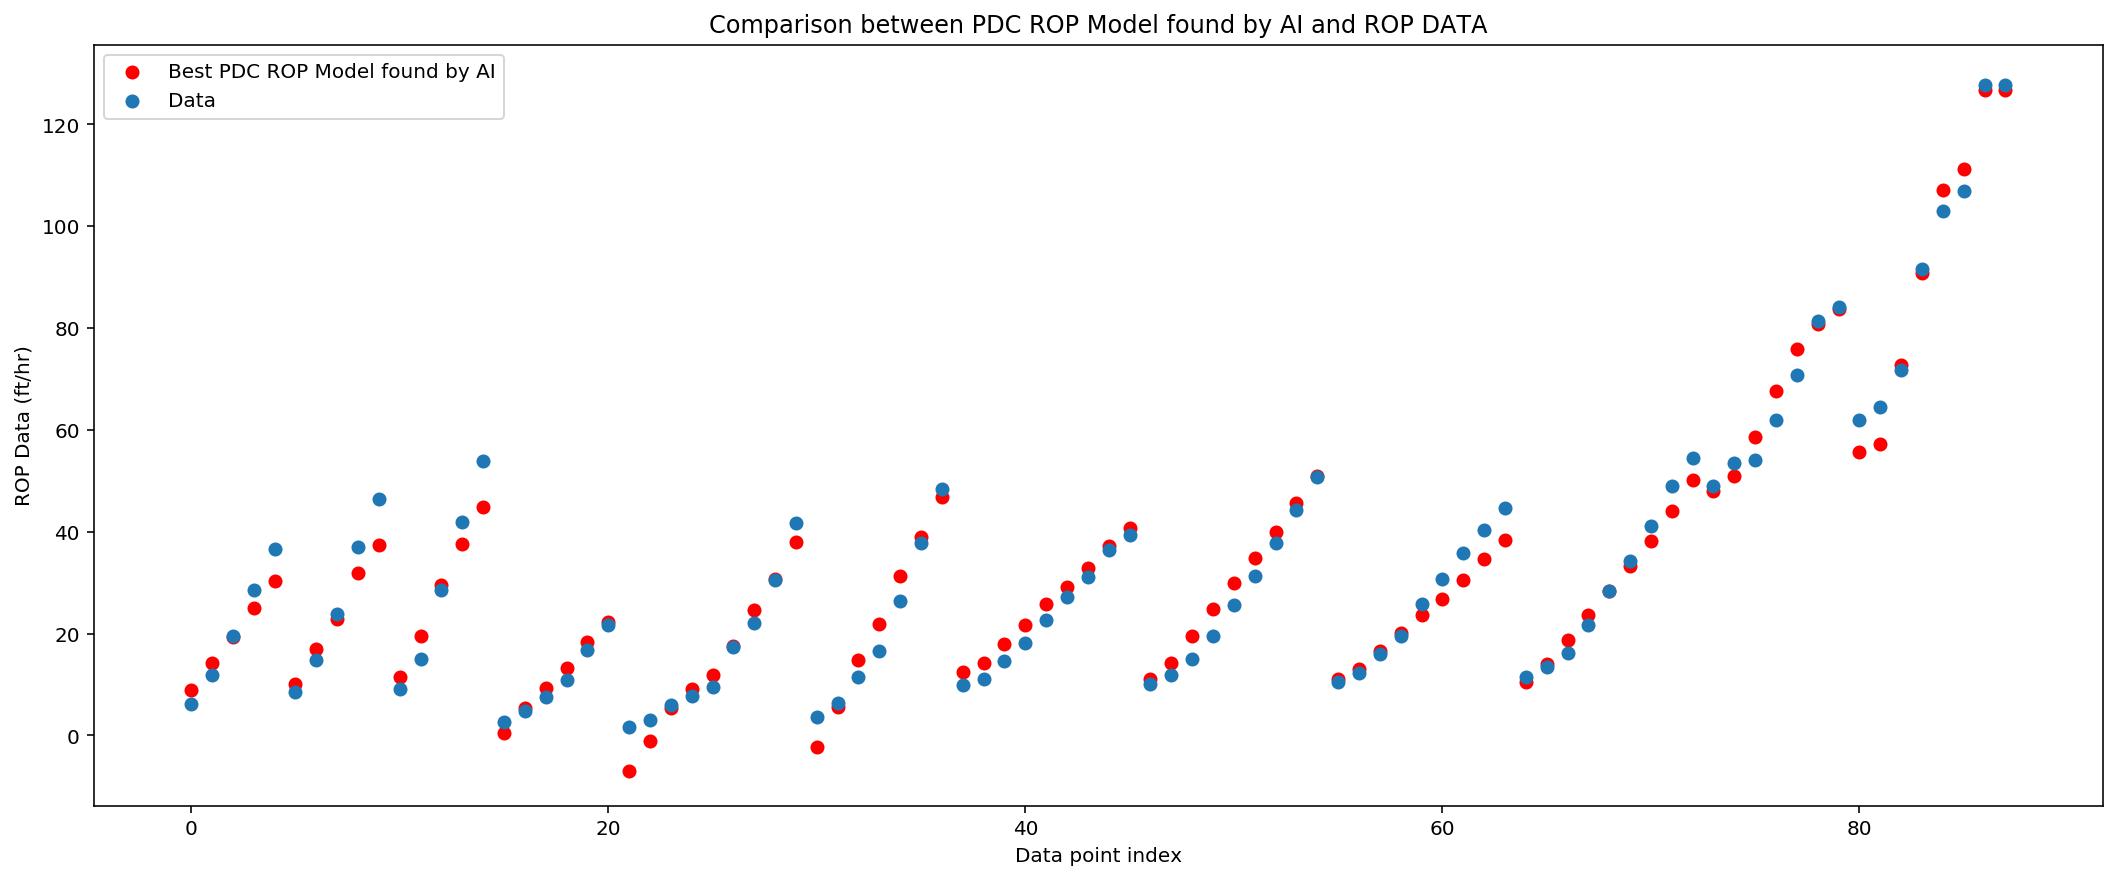

In [50]:
Data_points_index = np.array(range(0,len(estimated)))
estimated = np.apply_along_axis(best_equation, 1, X_np)
plt.figure(figsize=(18,7))
plt.scatter(Data_points_index, estimated, label="Best PDC ROP Model found by AI",c='r')
plt.scatter(Data_points_index, Y_np, label="Data")
plt.title("Comparison between PDC ROP Model found by AI and ROP DATA")
plt.xlabel("Data point index")
plt.ylabel("ROP Data (ft/hr)")
plt.legend()
# plt.show()
sys.path.insert(1, '../OpenSource_ROP_Models/ROP models/A PDC ROP model developed by AI/')
plt.savefig("../A PDC ROP model developed by AI/Figures/Comparison between PDC ROP Model found by AI and ROP DATA.png", \
            dpi=100)

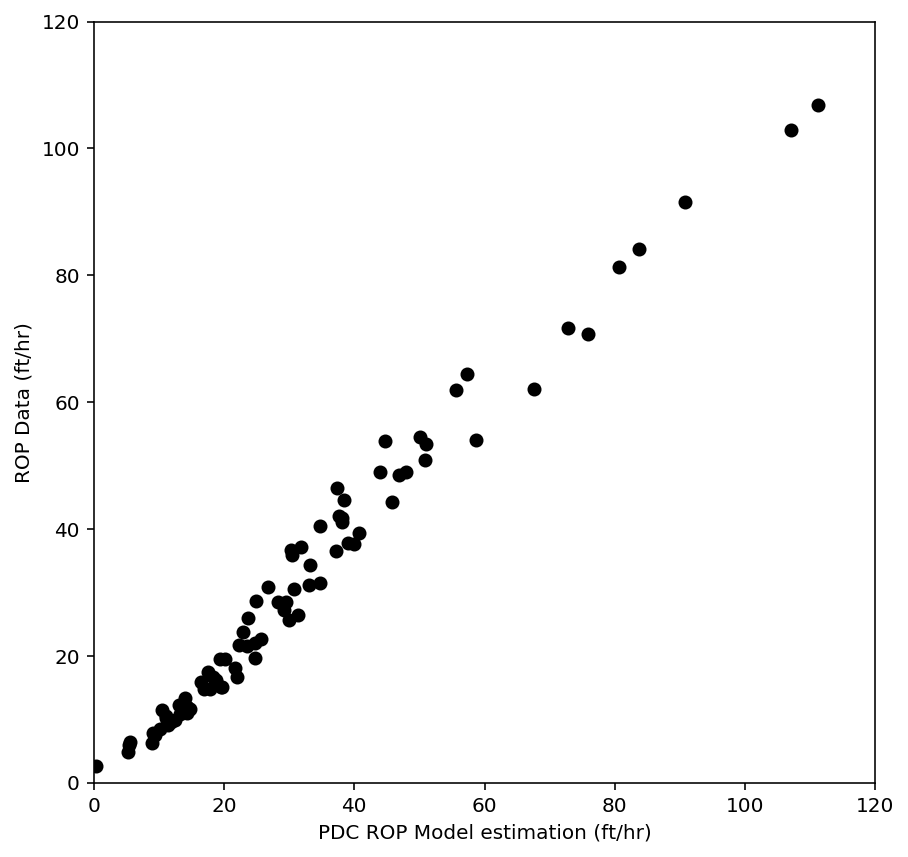

In [49]:
plt.figure(figsize=(7,7))
plt.scatter(estimated, Y_np, c='k')
plt.xlim(0,120),plt.xlabel("PDC ROP Model estimation (ft/hr)")
plt.ylim(0,120),plt.ylabel("ROP Data (ft/hr)")
# plt.show()
plt.savefig("../A PDC ROP model developed by AI/Figures/ModelvsData.png")